#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam
import datetime

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

In [ ]:
def decomp_plot_sales(Store_ID, sales, Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == Store_ID) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid, 'Date':temp['Date']})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['Date'], result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['Date'], result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['Date'], result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['Date'], result['residual'])
    plt.ylabel('residual')
    plt.show()

    print('\n')
    print('-'*50)
    print('잔차의 정규성')
    # print(pg.normality(result['residual']))
    print('-'*50,'\n')
    return result

In [ ]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'fall'
    else:
        return 'winter'

def get_date(df):
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['weekday'] = df['Date'].dt.dayofweek
    df['week'] = df['Date'].dt.isocalendar().week
    df['week'] = df['week'].astype('int')
    df['quarter']=df['Date'].dt.quarter
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

    return df

### **(3) 데이터 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/2024.04.25_미니프로젝트6차_Total/'

In [ ]:

oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [ ]:
def get_dataset(oil_price, orders, sales, products, stores):
    sales['Date'] = pd.to_datetime(sales['Date'] )
    oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
    orders['Date'] = pd.to_datetime(orders['Date'] )
    oil_price['dayWeek'] = oil_price['Date'].dt.dayofweek
    oil_price['WTI_Price'] = oil_price['WTI_Price'].interpolate()
    oil_price['WTI_Price'] = oil_price['WTI_Price'].fillna(method= 'bfill')

    print('oil_price 결측치 수', oil_price['WTI_Price'].isnull().sum())

    new_oil_price = pd.DataFrame({
    'Date' : [0],
    'WTI_Price' : [0],
    'dayWeek' : [0]
    })

    n=0
    for i in range(len(oil_price)):
        new_oil_price.loc[i+n] = oil_price.loc[i]
        if oil_price['dayWeek'].loc[i]==4:
            new_oil_price.loc[i+n+1] = [oil_price['Date'].loc[i]+ datetime.timedelta(days=1), oil_price['WTI_Price'].loc[i], 5]
            new_oil_price.loc[i+n+2] = [oil_price['Date'].loc[i]+ datetime.timedelta(days=2), oil_price['WTI_Price'].loc[i], 6]
            n+=2

    new_oil_price['Date'] = pd.to_datetime(new_oil_price['Date'] )

    product_sales = pd.merge(sales, products, on='Product_ID')
    store_orders = pd.merge(stores, orders, on='Store_ID')

    dataset = pd.merge(product_sales, store_orders, on=['Store_ID', 'Date'])
    dataset = pd.merge(dataset, new_oil_price, on='Date', how='left')

    return dataset

In [ ]:
train_dataset = get_dataset(oil_price, orders, sales, products, stores)

train_dataset.head()

oil_price 결측치 수 0


,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,dayWeek
0,2014-01-01,25,1415.000,3,DB001,Beverage,Drink,2,8,Olympia,Washington,4,840,95.14,2
1,2014-01-01,25,186.452,5,FB001,BAKERY,Food,2,6,Olympia,Washington,4,840,95.14,2
2,2014-01-01,25,232.000,7,HC001,Cleaning,Household Goods,2,15,Olympia,Washington,4,840,95.14,2
3,2014-01-01,25,358.000,8,FM001,Yogurt,Food,2,4,Olympia,Washington,4,840,95.14,2
4,2014-01-01,25,64.000,10,GE001,EGGS,Grocery,2,5,Olympia,Washington,4,840,95.14,2


## Testset

In [ ]:

oil_price_t = pd.read_csv(path + 'test/oil_price_test.csv')
orders_t = pd.read_csv(path + 'test/orders_test.csv')
sales_t = pd.read_csv(path + 'test/sales_test.csv')
products_t = pd.read_csv(path + 'test/products.csv')
stores_t = pd.read_csv(path + 'test/stores.csv')

test_dataset = get_dataset(oil_price_t, orders_t, sales_t, products_t, stores_t)

test_dataset.head()

oil_price 결측치 수 0


,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,dayWeek
0,2017-03-01,1,3343.000,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,1873,53.82,2
1,2017-03-01,1,564.652,5,FB001,BAKERY,Food,2,6,Saint Paul,\tMinnesota,4,1873,53.82,2
2,2017-03-01,1,1029.000,7,HC001,Cleaning,Household Goods,2,15,Saint Paul,\tMinnesota,4,1873,53.82,2
3,2017-03-01,1,1162.000,8,FM001,Yogurt,Food,2,4,Saint Paul,\tMinnesota,4,1873,53.82,2
4,2017-03-01,1,215.000,10,GE001,EGGS,Grocery,2,5,Saint Paul,\tMinnesota,4,1873,53.82,2


# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [ ]:
# 여기에 여러분이 생각하는 컬럼들을 선택해주세요
Selected_Features = ['year', 'month', 'day', 'weekday','is_weekend','CustomerCount', 'Qty']

def preprocessing(dataset, Selected_Features, Store_ID=44, Product_ID=3):            # train set과 test set 공통으로 진행하기 위해
    dataset = get_date(dataset)
    dataset = dataset[(dataset['Store_ID']==Store_ID) & (dataset['Product_ID']==Product_ID)]
    dataset = dataset[Selected_Features]
    dataset = dataset.reset_index(drop=True)
    dataset['Target_Qty'] = dataset['Qty'].shift(periods=-2)
    dataset = dataset.iloc[:-2].reset_index(drop=True)
    return dataset


## **(1) 상품 : 3 - Beverage**

In [ ]:
train_Beverage = preprocessing(train_dataset, Selected_Features, Store_ID=44, Product_ID=3)

train_Beverage.head()

,year,month,day,weekday,is_weekend,CustomerCount,Qty,Target_Qty
0,2014,1,2,3,0,4422,9853.0,15153.0
1,2014,1,3,4,0,4167,8647.0,15606.0
2,2014,1,4,5,1,5341,15153.0,7900.0
3,2014,1,5,6,1,5123,15606.0,7188.0
4,2014,1,6,0,0,3917,7900.0,8800.0


In [ ]:
test_Beverage = preprocessing(test_dataset, Selected_Features, Store_ID=44, Product_ID=3)

test_Beverage.head()

,year,month,day,weekday,is_weekend,CustomerCount,Qty,Target_Qty
0,2017,3,1,2,0,4146,10153.0,10257.0
1,2017,3,2,3,0,3882,8918.0,16991.0
2,2017,3,3,4,0,4483,10257.0,18304.0
3,2017,3,4,5,1,5382,16991.0,8413.0
4,2017,3,5,6,1,5423,18304.0,8360.0


## **(2) 상품 : 12 - Milk**

In [ ]:
train_Milk = preprocessing(train_dataset,Selected_Features,Store_ID=44,Product_ID=12)
train_Milk.head()

,year,month,day,weekday,is_weekend,CustomerCount,Qty,Target_Qty
0,2014,1,2,3,0,4422,9647.0,14188.0
1,2014,1,3,4,0,4167,8879.0,14490.0
2,2014,1,4,5,1,5341,14188.0,7614.0
3,2014,1,5,6,1,5123,14490.0,7124.0
4,2014,1,6,0,0,3917,7614.0,8683.0


In [ ]:
test_Milk = preprocessing(test_dataset,Selected_Features,Store_ID=44, Product_ID=12)
test_Milk.head()

,year,month,day,weekday,is_weekend,CustomerCount,Qty,Target_Qty
0,2017,3,1,2,0,4146,11307.0,11207.0
1,2017,3,2,3,0,3882,9761.0,16590.0
2,2017,3,3,4,0,4483,11207.0,18768.0
3,2017,3,4,5,1,5382,16590.0,8985.0
4,2017,3,5,6,1,5423,18768.0,8678.0


## **(3) 상품 : 42 - Agricultural products**

# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
target = 'Target_Qty'

x = train_Beverage.drop([target], axis = 1)
y = train_Beverage.loc[:, target]

x_test = test_Beverage.drop([target], axis = 1)
y_test = test_Beverage.loc[:, target]

In [ ]:
val_size = 7*7      # 2달씩 확인하기
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = val_size, shuffle = False)


In [ ]:
# 스케일링

# x
scaler_x = MinMaxScaler()
x_train_s2 = scaler_x.fit_transform(x_train)
x_val_s2 = scaler_x.transform(x_val)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

# x_test
scaler_x = MinMaxScaler()
x_test_s2 = scaler_x.fit_transform(x_test)                          # fit_transform
# x_val_s2 = scaler_x.transform(x_val)

# y_test에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_test_s2 = scaler_y.fit_transform(y_test.values.reshape(-1,1))     # fit_transform
# y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

### **2) 모델링**

In [ ]:
nfeatures = x_train_s2.shape[1]

clear_session()

model1 = Sequential([Dense(16, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

In [ ]:
hist = model1.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

Epoch 1/50


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0417 - val_loss: 0.0361
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0274 - val_loss: 0.0299
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0208 - val_loss: 0.0262
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0195 - val_loss: 0.0243
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0226
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181 - val_loss: 0.0194
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0160 - val_loss: 0.0172
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0134 - val_loss: 0.0166
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0156
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119 - val_loss: 0.0159
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.0151
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0102 - val_loss: 0.0146


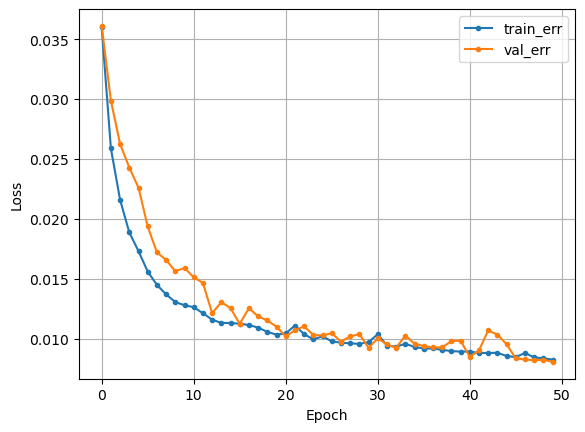

In [ ]:
dl_history_plot(hist)

### 예측 및 평가와 시각화

In [ ]:
pred = model1.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE : 2187.377331792092
MAPE: 0.20444506235600673
R2  : 0.4352050964454782


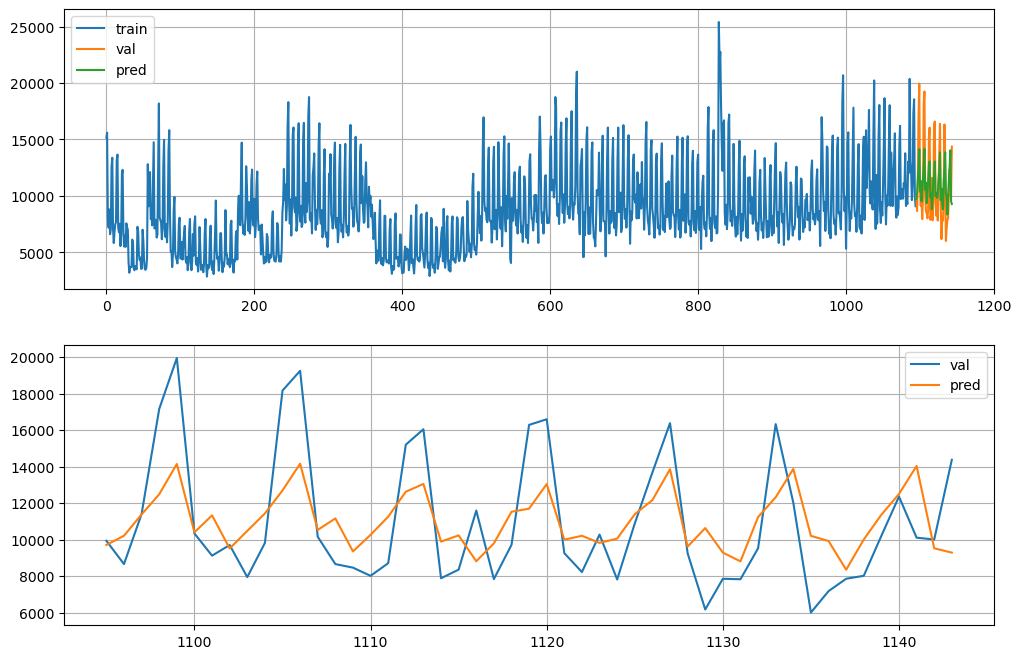

In [ ]:
plot_model_result(y_train, y_val, pred)

### 테스트셋 예측 및 평가와 시각화

In [ ]:
pred = model1.predict(x_test_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_test, pred))
print('MAPE:', mean_absolute_percentage_error(y_test, pred))
print('R2  :', r2_score(y_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE : 3399.5779397898705
MAPE: 0.24536223839168142
R2  : -0.2898200581714483


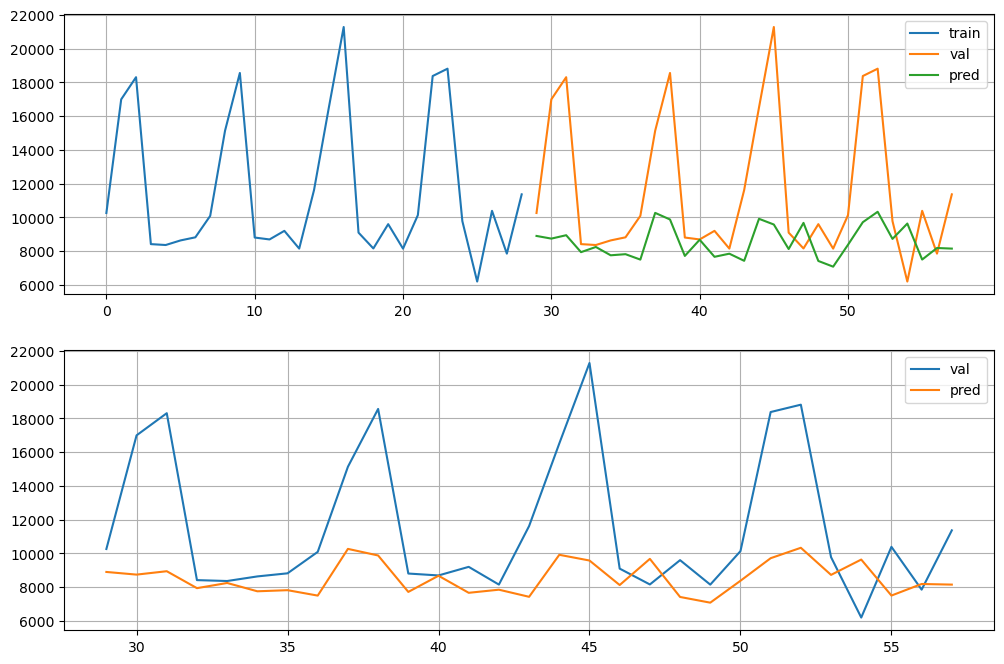

In [ ]:
plot_model_result(y_test, y_test, pred)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [ ]:
target = 'Target_Qty'

x = train_Milk.drop([target],axis = 1)
y = train_Milk.loc[:, target]

x_test = test_Milk.drop([target],axis = 1)
y_test = test_Milk.loc[:, target]

In [ ]:
val_size = 7*7
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = val_size, shuffle = False)

In [ ]:
# 스케일링

# x
scaler_x = MinMaxScaler()
x_train_s2 = scaler_x.fit_transform(x_train)
x_val_s2 = scaler_x.transform(x_val)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

# x_test
x_test_s2 = scaler_x.fit_transform(x_test)
# y_test는 결과 값이므로 안한다.

### **2) 모델링**

In [ ]:
nfeatures = x_train_s2.shape[1]

clear_session()

model1 = Sequential([Dense(16, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

In [ ]:
hist = model1.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 [==============================] - 1s 15ms/step - loss: 0.0614 - val_loss: 0.0134
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0247 - val_loss: 0.0080
Epoch 3/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 5/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0112
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0113
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0112
Epoch 8/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0109
Epoch 9/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0107
Epoch 10/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 11/50
28/28 

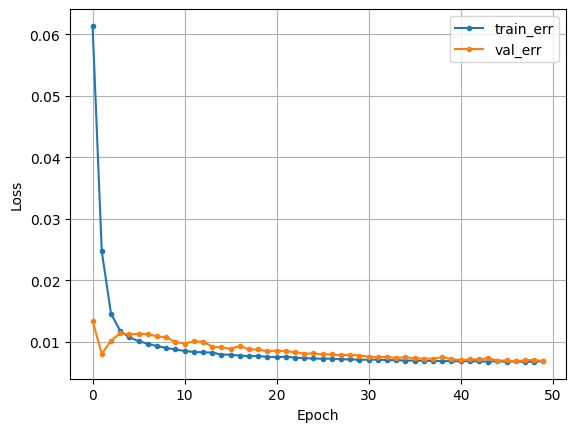

In [ ]:
dl_history_plot(hist)

### 예측 및 평가와 시각화

In [ ]:
pred = model1.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

2/2 [==============================] - 0s 10ms/step
MAE : 2027.893833705357
MAPE: 0.20760584009692393
R2  : 0.3585688620881172


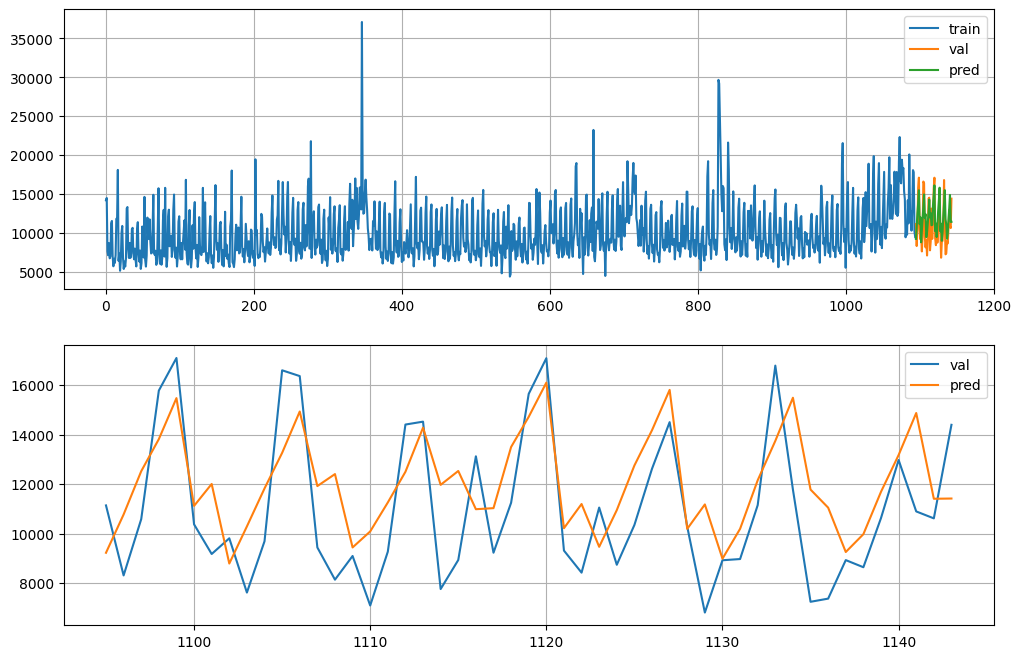

In [ ]:
plot_model_result(y_train, y_val, pred)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

### **2) 모델링**

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
### 4) 2차원 --> 3차원 변환(for LSTM, CNN)

def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        output_X.append(x.iloc[i:i+timestep])
        output_y.append(y.iloc[i+timestep-1])
    return np.array(output_X), np.array(output_y)


'''
### 5) 스케일링을 위한 함수
* LSTM, CNN를 위한 데이터를 스케일링 하는 것은 조금 까다로움.
* 원본 데이터는 2D, 모델링 하기 위한 데이터셋(X)은 3D.
* 이를 위해 두 함수를 생성합니다.
    * flatten : 3차원을 2차원으로 돌려 놓는 함수
    * scale : 3차원 데이터에 스케일러 적용(transform)

'''

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
target = 'Target_Qty'

x = train_Beverage.drop([target], axis = 1)
y = train_Beverage.loc[:, target]

x_test = test_Beverage.drop([target], axis = 1)
y_test = test_Beverage.loc[:, target]

In [ ]:
timesteps = 7          # 7
x2, y2 = temporalize(x, y, timesteps)

x2_test, y2_test = temporalize(x_test, y_test, timesteps)

val_size = 7 * 7       # 7*7
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)


In [ ]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

############################

# 3차원 데이터에 스테일러 적용
scaler = MinMaxScaler().fit(flatten(x2_test))
x_test_s3 = scale(x2_test, scaler)
# x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_test_s3 = scaler_y.fit_transform(y2_test.reshape(-1,1))
# y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))


* **모델링**

In [ ]:

n_features = x_train_s3.shape[2]

clear_session()

model2 = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                    # Flatten(),
                    Dense(1)])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

In [ ]:
hist = model2.fit(x_train_s3, y_train_s3, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0504 - val_loss: 0.0147
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0095
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - val_loss: 0.0106
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0058
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0050
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0124
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0051
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_lo

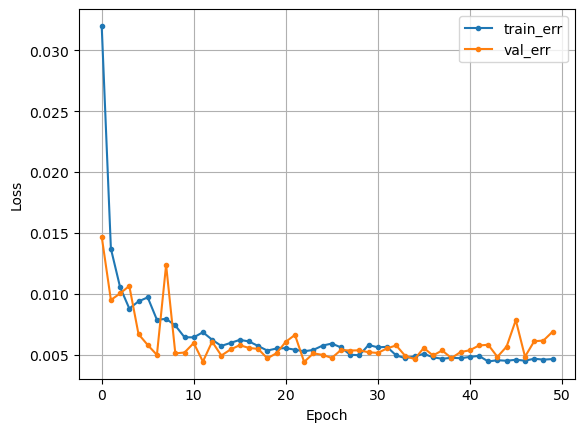

In [ ]:
dl_history_plot(hist)

#### 예측 및 평가와 시각화

In [ ]:
pred = model2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/stepWARNING:tensorflow:6 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000292330A6020> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
MAE : 2117.5566705197703
MAPE: 0.22717258587033287
R2  : 0.44834487178687055


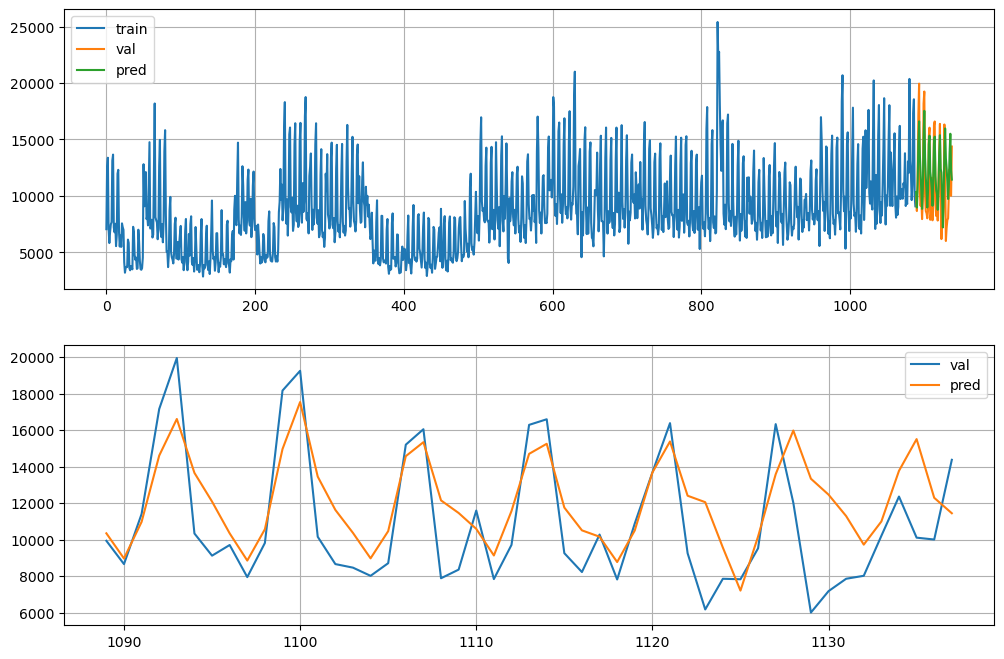

In [ ]:
plot_model_result(y_train, y_val, pred)

### 테스트셋 예측 및 평가와 시각화

In [ ]:
pred = model2.predict(x_test_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y2_test, pred))
print('MAPE:', mean_absolute_percentage_error(y2_test, pred))
print('R2  :', r2_score(y2_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE : 2348.1149583899455
MAPE: 0.17534976781235656
R2  : 0.2785065097606024


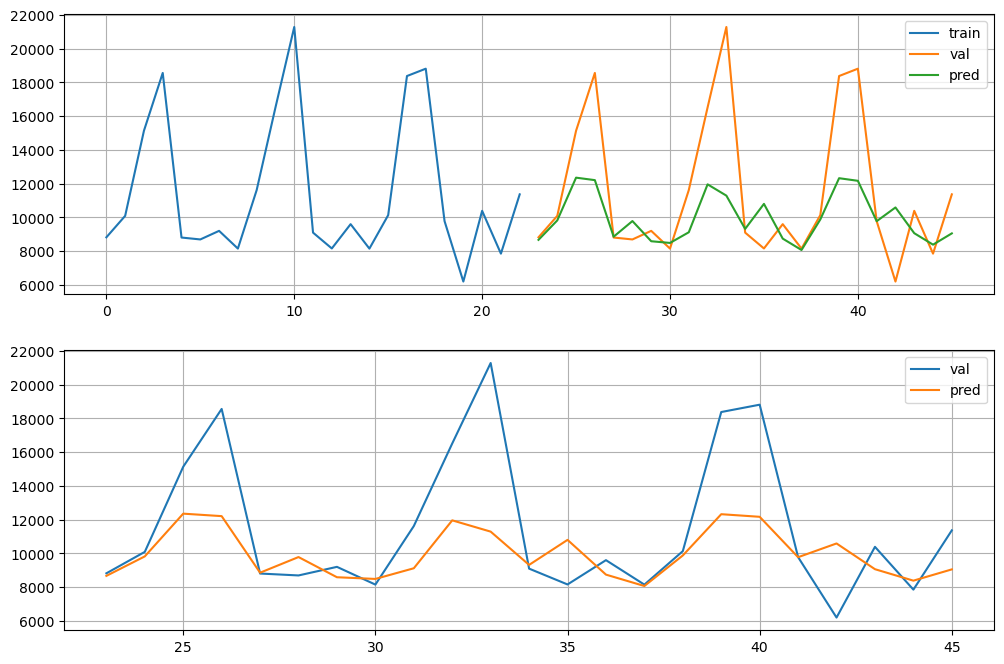

In [ ]:
plot_model_result(y2_test, y2_test, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
target = 'Target_Qty'

x = train_Milk.drop([target], axis = 1)
y = train_Milk.loc[:, target]

x_test = test_Milk.drop([target], axis = 1)
y_test = test_Milk.loc[:, target]

In [ ]:
timesteps = 7          # 7
x2, y2 = temporalize(x, y, timesteps)

x2_test, y2_test = temporalize(x_test, y_test, timesteps)

val_size = 7 * 7       # 7*7
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

In [ ]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

############################

# 3차원 데이터에 스케일러 적용
scaler = MinMaxScaler().fit(flatten(x2_test))
x_test_s3 = scale(x2_test, scaler)
# x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_test_s3 = scaler_y.fit_transform(y2_test.reshape(-1,1))
# y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))


* **모델링**

In [ ]:
n_features = x_train_s3.shape[2]

clear_session()

model2 = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                    # Flatten(),
                    Dense(1)])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

In [ ]:
hist = model2.fit(x_train_s3, y_train_s3, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 [==============================] - 4s 23ms/step - loss: 0.0194 - val_loss: 0.0087
Epoch 2/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 5/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 7/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 8/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 9/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 10/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 11/50
28/28 

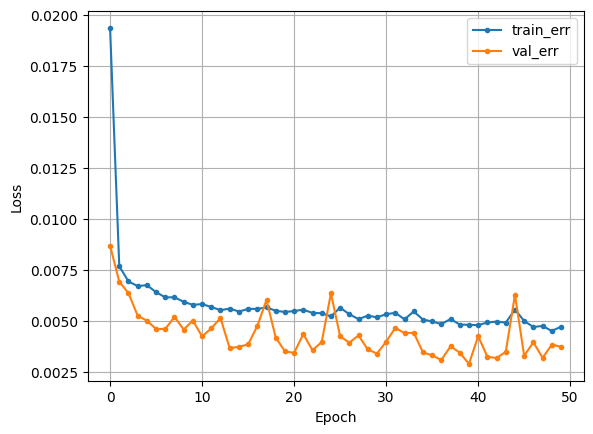

In [ ]:
dl_history_plot(hist)

### 예측 및 평가, 시각화

In [ ]:
pred = model2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

2/2 [==============================] - 1s 10ms/step
MAE : 3006.736308195153
MAPE: 0.24303103678347213
R2  : -0.6058609945476754


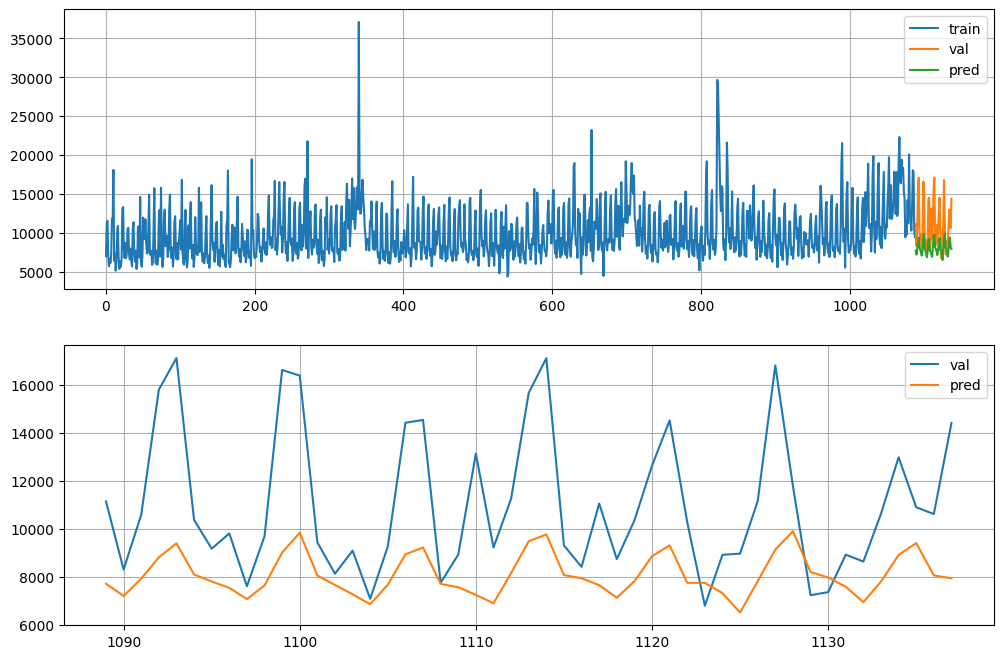

In [ ]:
plot_model_result(y_train, y_val, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
target = 'Target_Qty'

x = train_Beverage.drop([target], axis = 1)
y = train_Beverage.loc[:, target]

x_test = test_Beverage.drop([target], axis = 1)
y_test = test_Beverage.loc[:, target]

In [ ]:
timesteps = 7
x2, y2 = temporalize(x, y, timesteps)

x2_test, y2_test = temporalize(x_test, y_test, timesteps)

val_size = 7 * 7
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)


In [ ]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))


############################

# 3차원 데이터에 스테일러 적용
scaler = MinMaxScaler().fit(flatten(x2_test))
x_test_s3 = scale(x2_test, scaler)
# x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_test_s3 = scaler_y.fit_transform(y2_test.reshape(-1,1))
# y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

* **모델링**

In [ ]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

In [ ]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0959 - val_loss: 0.0111
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083 - val_loss: 0.0059
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - val_loss: 0.0091
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075 - val_loss: 0.0065
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0050
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_lo

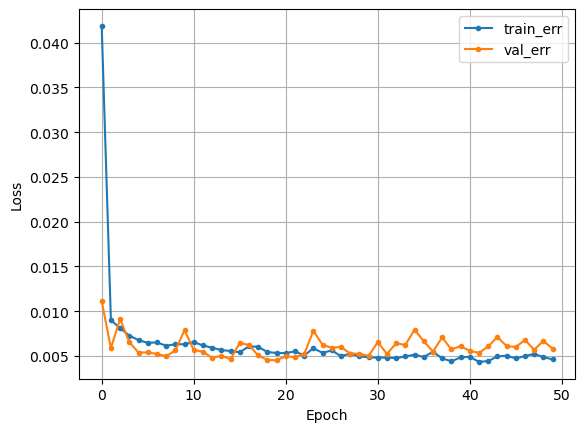

In [ ]:
dl_history_plot(hist)

#### 예측 및 평가와 시각화

In [ ]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE : 2130.468331473214
MAPE: 0.2304764141669023
R2  : 0.476079386396033


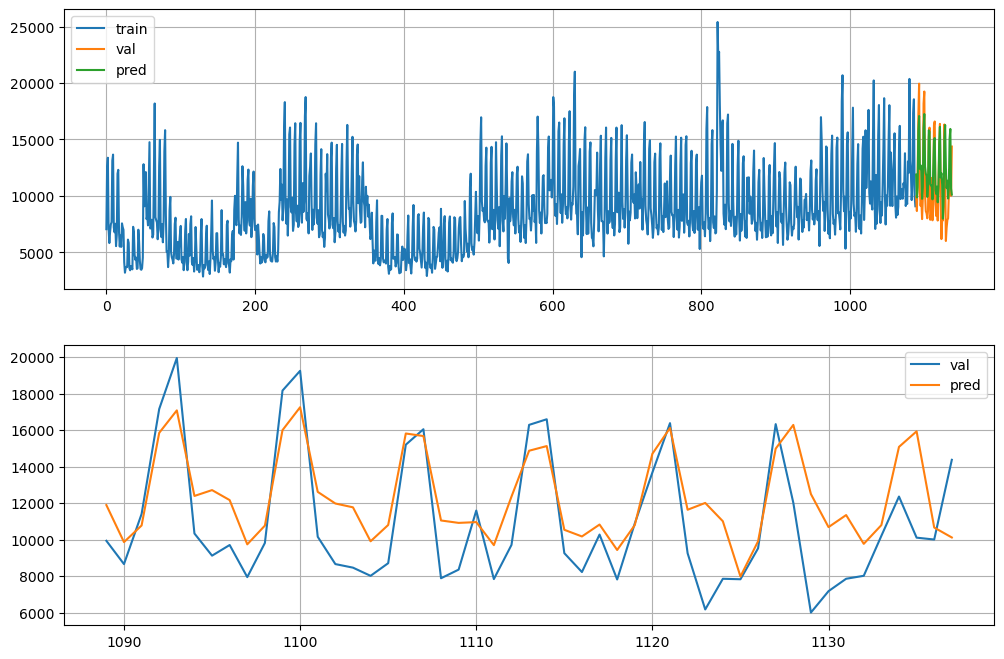

In [ ]:
plot_model_result(y_train, y_val, pred)

### 테스트셋 예측 및 평가와 시각화

In [ ]:
pred = model3.predict(x_test_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y2_test, pred))
print('MAPE:', mean_absolute_percentage_error(y2_test, pred))
print('R2  :', r2_score(y2_test, pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE : 2372.6147673233695
MAPE: 0.18263940065325013
R2  : 0.34422203063242207


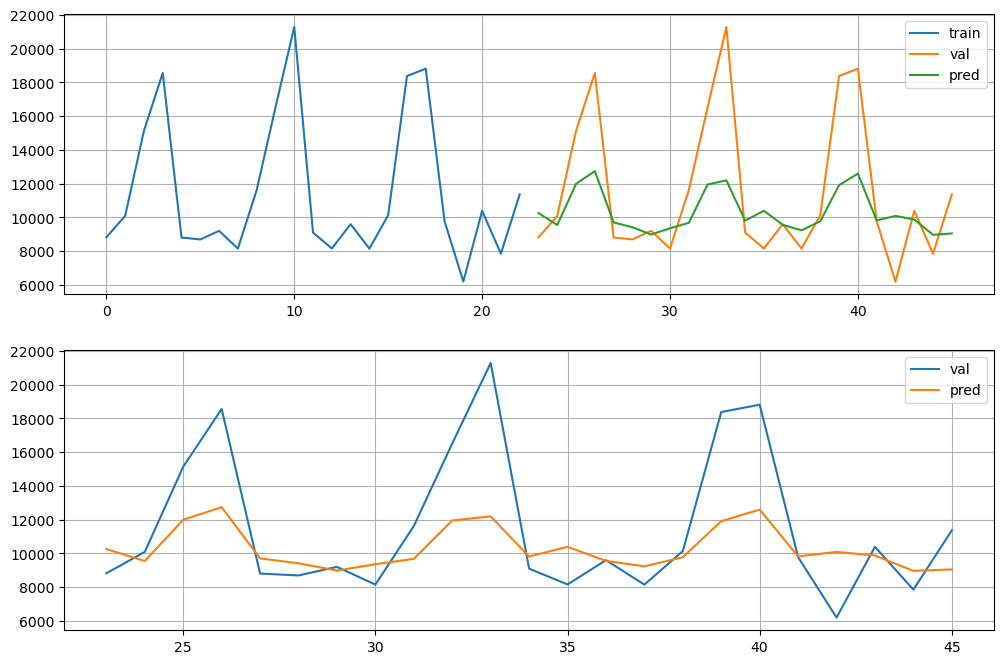

In [ ]:
plot_model_result(y2_test, y2_test, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
target = 'Target_Qty'

x = train_Milk.drop([target], axis = 1)
y = train_Milk.loc[:, target]

x_test = test_Milk.drop([target], axis = 1)
y_test = test_Milk.loc[:, target]

In [ ]:
timesteps = 7
x2, y2 = temporalize(x, y, timesteps)

x2_test, y2_test = temporalize(x_test, y_test, timesteps)

val_size = 7 * 7
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)


In [ ]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))


############################

# 3차원 데이터에 스테일러 적용
scaler = MinMaxScaler().fit(flatten(x2_test))
x_test_s3 = scale(x2_test, scaler)
# x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_test_s3 = scaler_y.fit_transform(y2_test.reshape(-1,1))
# y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

* **모델링**

In [ ]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

In [ ]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 [==============================] - 2s 14ms/step - loss: 0.0171 - val_loss: 0.0078
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 3/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 6/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 8/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 9/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 10/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 11/50
28/28 

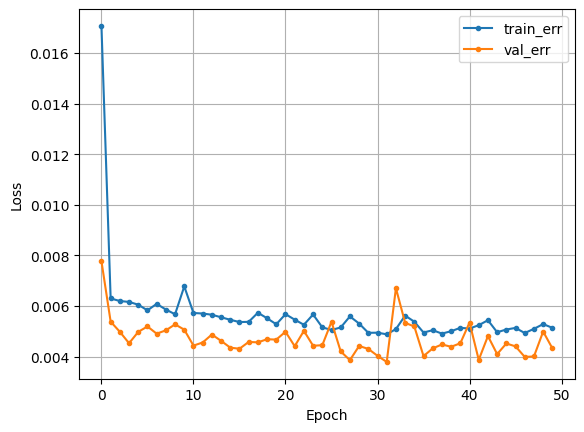

In [ ]:
dl_history_plot(hist)

### 예측 및 평가, 시각화

In [ ]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

2/2 [==============================] - 0s 18ms/step
MAE : 3598.2717235331634
MAPE: 0.3013373521962045
R2  : -1.0349944808549134


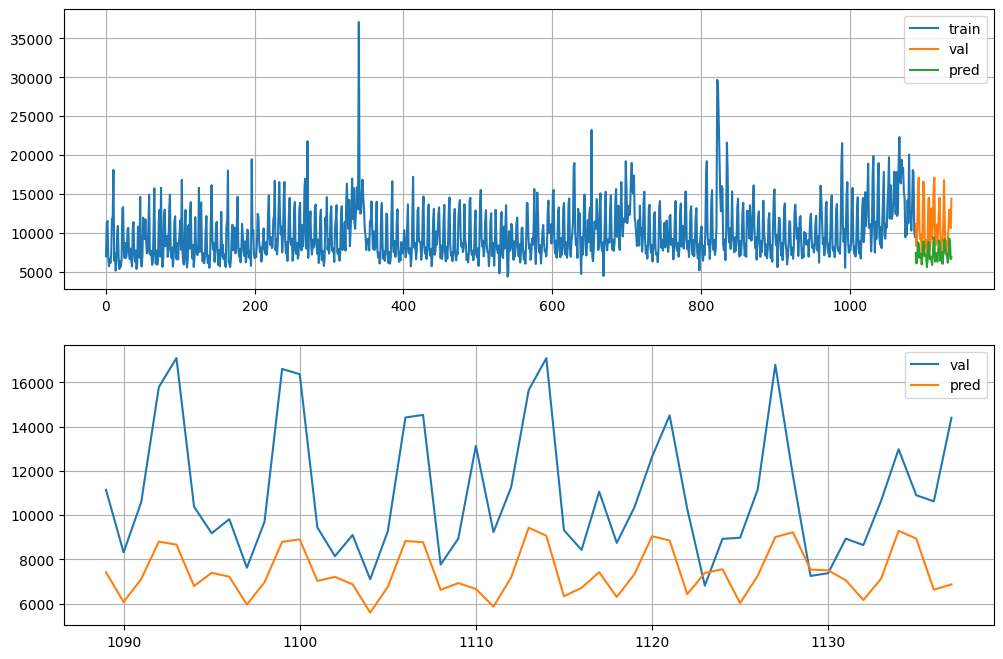

In [ ]:
plot_model_result(y_train, y_val, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

## **(3) 머신러닝 모델링**

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.